In [2]:
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from itertools import permutations
from utils.eda import eda

In [66]:
sample_data = True

df = pd.read_csv("data/tapaco_en.csv")
df.drop(columns=["lists", "tags", "language"], inplace=True)
df["paraphrase"] = df["paraphrase"].str.lower()
if sample_data:
  indexes = random.choices(df["paraphrase_set_id"].unique(), k=10000)
  df = df[df["paraphrase_set_id"].isin(indexes)]

In [67]:
train_indexes = df[df.paraphrase_set_id % 10 != 0].index
valid_indexes = df[df.paraphrase_set_id % 10 == 0].index

In [68]:
def match_pairs(df, index):
    df = df.loc[index]
    df.set_index(['paraphrase_set_id', 'sentence_id'], inplace=True)
    new_df = []
    for id, group in tqdm(df.groupby(level=0)):
        for seta, setb in permutations(group['paraphrase'], 2):
            new_df.append({'id': id, 'setA':seta, 'setB':setb})
    return pd.DataFrame.from_records(new_df)

In [69]:
train_df = match_pairs(df, train_indexes)
valid_df = match_pairs(df, valid_indexes)

100%|██████████| 913/913 [00:00<00:00, 15460.95it/s]


In [72]:
def get_other(df):
    df["other"] = None
    for index in tqdm(df.index):
        examples = df.sample(1000, replace=True)
        i = 0
        while df.loc[index, "other"] is None:
            if df.loc[index, "id"] != examples.iloc[i]["id"]:
                df.loc[index, "other"] = examples.iloc[i]["setB"]
            i += 1
    return df

In [73]:
train_df = get_other(train_df)
valid_df = get_other(valid_df)

100%|██████████| 7796/7796 [00:04<00:00, 1726.10it/s]


In [74]:
train = Dataset.from_pandas(train_df, split="train")
valid = Dataset.from_pandas(valid_df, split="valid")
data = DatasetDict({"train": train, "valid": valid})

In [75]:
for ex in zip(*data["train"].shuffle()[:10].values()):
    print(ex)

(356654, 'tom likes football.', 'tom loves football.', 'my grandfather used to love reading.')
(13809, "look out! there's a car coming.", 'look out for the car.', "do you have any idea what's going to happen?")
(139958, "you need to take responsibility for what you've done.", "you will have to be responsible for what you've done.", 'she acknowledged her mistake.')
(1963, "you can't have it both ways.", 'better a little than nothing.', "tom is convinced he's right.")
(16475, 'he loves traveling.', 'he loved to travel.', 'what a wonderful view!')
(2142, "it looks like it'll rain today, too.", 'it might rain.', "i don't know his name.")
(447, 'you love her.', 'he wants that.', 'tom is all talk.')
(1893, "let's step outside.", "let's go outside.", 'he loves him.')
(370497, 'nobody knows who did that.', 'no one knows who did it.', "i'll go tomorrow if the weather is reasonable.")
(475236, 'tom has been very quiet.', 'tom was very quiet.', 'it may rain.')


In [76]:
def batched_eda(examples):
    return [eda(example, alpha_sr=.0, alpha_rs=.1, alpha_ri=.0, p_rd=.2, num_aug=1)[0] for example in examples]

In [77]:
def gen_examples(examples):
  result = {
      "setA": examples["setA"],
      "setB": examples["setB"],
      "other": examples["other"],
      "fake": batched_eda(examples["setA"]) # create fake paraphrasing
    }
  return result

In [78]:
data = data.map(
    gen_examples,
    remove_columns=["id"],
    batched=True,
    num_proc=8,
)

#0:   0%|          | 0/9 [00:00<?, ?ba/s]

#1:   0%|          | 0/9 [00:00<?, ?ba/s]

#2:   0%|          | 0/9 [00:00<?, ?ba/s]

#3:   0%|          | 0/9 [00:00<?, ?ba/s]

#4:   0%|          | 0/9 [00:00<?, ?ba/s]

#5:   0%|          | 0/9 [00:00<?, ?ba/s]

#6:   0%|          | 0/9 [00:00<?, ?ba/s]

#7:   0%|          | 0/9 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#5:   0%|          | 0/1 [00:00<?, ?ba/s]

#7:   0%|          | 0/1 [00:00<?, ?ba/s]

#6:   0%|          | 0/1 [00:00<?, ?ba/s]

In [79]:
for ex in zip(*data["train"].shuffle()[:10].values()):
    print(ex)

('the police arrested him.', 'did the police arrest him?', 'matters are different now.', 'the police arrested him.')
("they won't make it.", "they'll never make it.", 'but you have never spoken to me about that!', 'they make it.')
('come over here and help me.', 'come here and help.', 'i have complete confidence in you.', 'come over here and help me.')
('she punched him in the face.', 'she slapped his face.', 'they looked satisfied with the result.', 'she punched him the')
("i know you're not scared.", "i know you aren't scared.", 'the gate is open.', "know you're not scared.")
('it was from her.', 'it was from him.', 'graham greene is a favorite author of mine.', 'it from her.')
('we should turn back.', 'we are coming back!', "i'm fed up with your complaining.", 'we back.')
('i agreed with his plan.', 'i approve of your plan.', 'they captured foxes with snares.', 'i with his plan.')
('the higher you fly, the harder you fall.', 'you cannot eat your cake and have it too.', "we're on our

In [80]:
def jaccard_similarity(x,y):
    """ returns the jaccard similarity between two lists """
    x = x.split()
    y = y.split()
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

In [81]:
def transform(example):
    if random.random() < .5:
        if random.random() < .3:
            example["setB"] = example["other"]
            example["labels"] = -1.5
        else:
            example["setB"] = example["fake"]
            example["labels"] = -.0
    else:
        if random.random() < .3:
            example["setB"] = example["setB"][:-1]
        example["labels"] = 1.5 - jaccard_similarity(example["setA"], example["setB"])
    return example

In [82]:
data = data.map(
    transform,
    remove_columns=["other", "fake"],
)

  0%|          | 0/65820 [00:00<?, ?ex/s]

  0%|          | 0/7796 [00:00<?, ?ex/s]

In [83]:
data["train"][0]

{'setA': 'he refused to say more about that.',
 'setB': 'she refuses to say more about it',
 'labels': 0.6}

In [84]:
df = []
for split in ["train", "valid"]:
    for x in data[split]:
        if split == "train":
            df.append({
                "lenA":len(x["setA"]),
                "lenB":len(x["setB"]),
                "reward":x["labels"],
                "split":split,
            })

In [85]:
df = pd.DataFrame.from_records(df)

<AxesSubplot:>

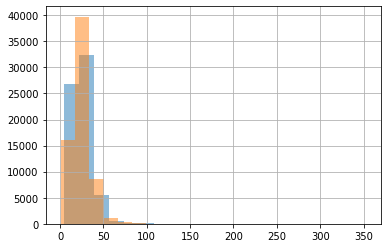

In [86]:
df.lenA.hist(bins=20, alpha=.5)
df.lenB.hist(bins=20, alpha=.5)

In [87]:
df.describe()

,lenA,lenB,reward
count,65820.000000,65820.000000,65820.000000
mean,25.646293,24.563886,-0.047721
std,11.005970,10.929771,0.854149
min,4.000000,1.000000,-1.500000
25%,19.000000,18.000000,-0.550000
50%,23.000000,23.000000,0.090909
75%,30.000000,29.000000,0.777778
max,352.000000,329.000000,1.000000


<AxesSubplot:>

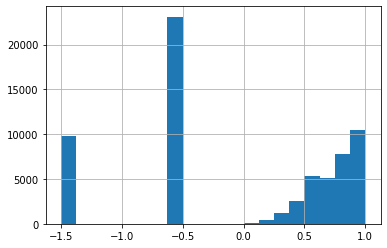

In [88]:
df.reward.hist(bins=20);